# Setup and Data Loading
Start by importing necessary libraries and loading the data

In [70]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Set seed for reproducibility
np.random.seed(1234)

# load the data
# add as header the columns names: statement_id, label, statement, subject, speaker, job_title, state, party, barely_true_c, false_c, half_true_c, mostly_true_c, pants_on_fire_c, context
header = ['statement_id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'context']
test_data = pd.read_csv('./liar_dataset/test.tsv', sep='\t', names=header)
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', names=header)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', names=header)
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


# Text Preprocessing
Next, preprocess the text data:

In [71]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Preprocess the text (for 'statement' and 'job_title')
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

train_data['processed_text'] = train_data['statement'].apply(preprocess_text)
train_data['processed_job_title'] = train_data['job_title'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Topic Modeling with LDA
This section handles topic modeling using LDA (Latent Dirichlet Allocation).

In [76]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# Create a dictionary and corpus for the LDA model
dictionary = corpora.Dictionary(train_data['processed_text'])
corpus = [dictionary.doc2bow(text) for text in train_data['processed_text']]


In [77]:

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=6, id2word=dictionary, passes=20)

# Display the topics discovered by the model
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)
    
    


(0, '0.024*"obama" + 0.023*"president" + 0.016*"republican" + 0.015*"say" + 0.014*"barack" + 0.010*"year" + 0.010*"party" + 0.009*"vote" + 0.009*"time" + 0.008*"percent"')
(1, '0.043*"tax" + 0.026*"year" + 0.023*"say" + 0.020*"percent" + 0.015*"cut" + 0.014*"billion" + 0.014*"pay" + 0.011*"million" + 0.009*"family" + 0.008*"dollar"')
(2, '0.043*"state" + 0.019*"job" + 0.014*"percent" + 0.012*"wisconsin" + 0.010*"rate" + 0.009*"united" + 0.009*"school" + 0.009*"texas" + 0.009*"say" + 0.009*"country"')
(3, '0.024*"say" + 0.013*"people" + 0.011*"said" + 0.009*"clinton" + 0.009*"obama" + 0.008*"would" + 0.008*"dont" + 0.007*"hillary" + 0.006*"bill" + 0.006*"gun"')
(4, '0.034*"say" + 0.012*"trump" + 0.009*"law" + 0.009*"donald" + 0.008*"city" + 0.008*"voting" + 0.008*"illegal" + 0.007*"school" + 0.006*"child" + 0.006*"voted"')
(5, '0.035*"health" + 0.031*"care" + 0.017*"say" + 0.015*"law" + 0.012*"percent" + 0.012*"state" + 0.011*"bill" + 0.011*"insurance" + 0.007*"since" + 0.007*"act"')


In [78]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [79]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

# Save the visualization as an HTML file
pyLDAvis.save_html(lda_display, 'lda_visualization.html')

# Optionally, you can open it directly in the browser
import webbrowser
webbrowser.open('lda_visualization.html')

True

label           barely-true  false  half-true  mostly-true  pants-fire  true
dominant_topic                                                              
0                       238    325        263          295         139   246
1                       382    420        512          475         160   367
2                       318    397        511          477         148   409
3                       270    293        318          277         170   222
4                       214    283        249          202         106   232
5                       232    277        261          236         116   200


<Axes: xlabel='dominant_topic'>

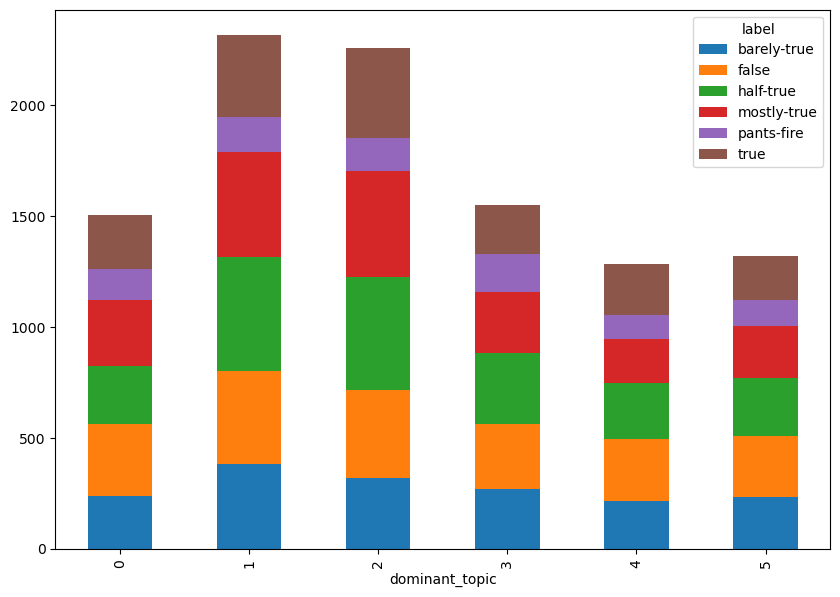

In [80]:

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Display the distribution
print(label_distribution_by_topic)

# Optionally, you can visualize the distribution using a bar chart
label_distribution_by_topic.plot(kind='bar', stacked=True, figsize=(10, 7))


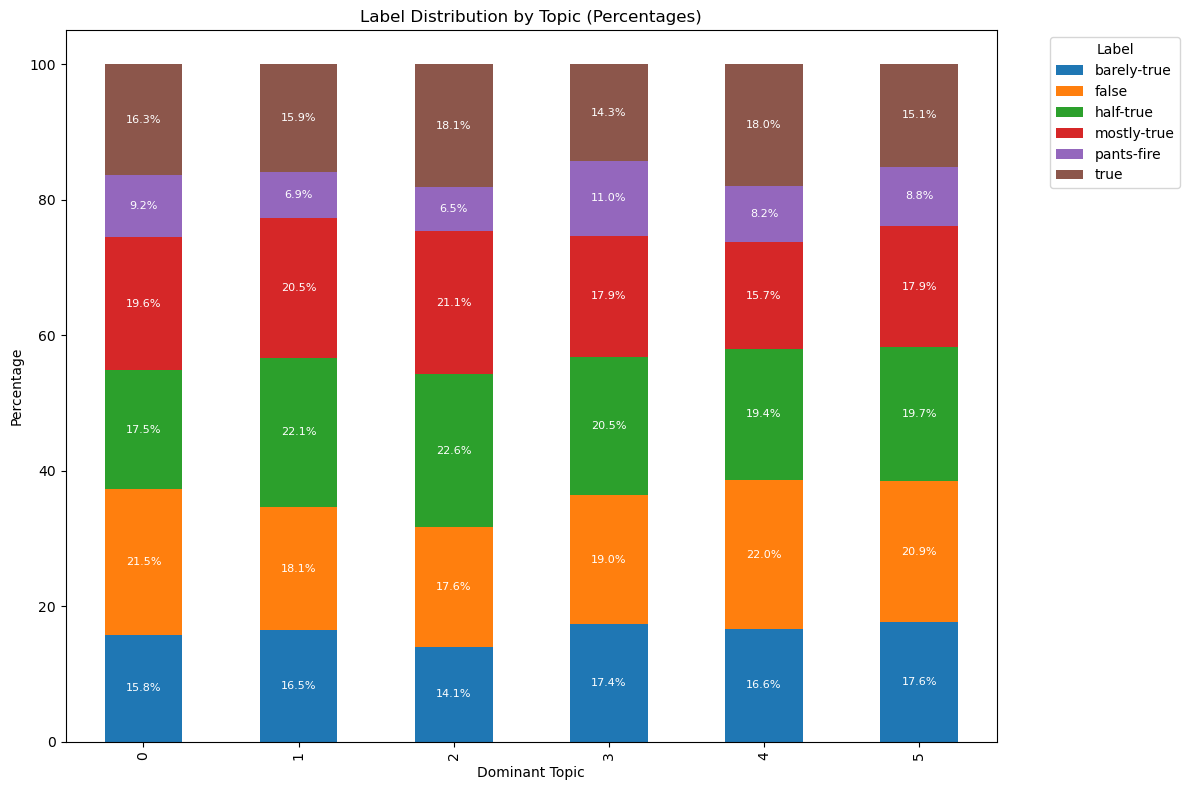

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Calculate the percentage distribution within each topic
label_distribution_percentages = label_distribution_by_topic.div(label_distribution_by_topic.sum(axis=1), axis=0) * 100

# Plot the percentage distribution
fig, ax = plt.subplots(figsize=(12, 8))
label_distribution_percentages.plot(kind='bar', stacked=True, ax=ax)

# Add percentages on the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Only label non-zero segments
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=8, color='white')

# Move the legend outside the plot
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Label Distribution by Topic (Percentages)')
plt.xlabel('Dominant Topic')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

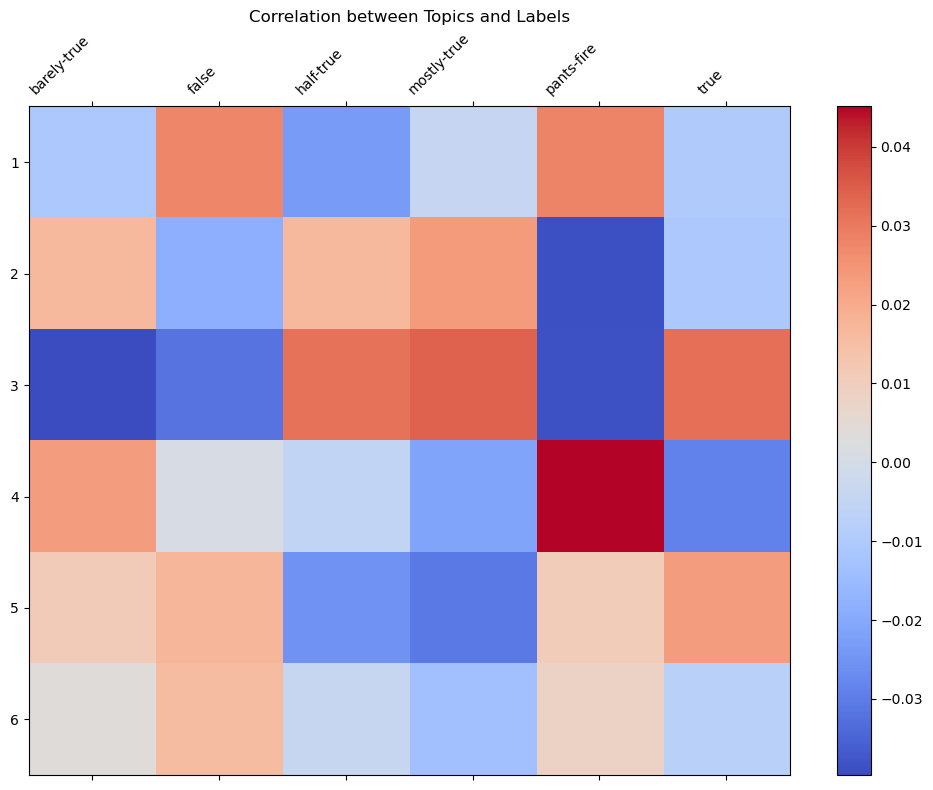

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Convert topic distributions to a DataFrame
topic_df = pd.DataFrame([dict(dist) for dist in topic_distributions])

# Add the labels to the DataFrame
topic_df['label'] = train_data['label'].values

# One-hot encode the labels for correlation calculation
label_encoded = pd.get_dummies(topic_df['label'])

# Initialize an empty DataFrame to store the correlations
correlation_df = pd.DataFrame(index=topic_df.columns[:-1], columns=label_encoded.columns)

# Calculate the correlation between each topic and each label
for topic in correlation_df.index:
    for label in correlation_df.columns:
        correlation_df.loc[topic, label] = topic_df[topic].corr(label_encoded[label])

# Convert to float (correlations are numeric)
correlation_df = correlation_df.astype(float)

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_df, cmap='coolwarm', aspect='auto')

# Add a colorbar
fig.colorbar(cax)

# Set the x-axis and y-axis labels
ax.set_xticks(range(len(correlation_df.columns)))
ax.set_yticks(range(len(correlation_df.index)))
ax.set_xticklabels(correlation_df.columns, rotation=45, ha='right')

# Adjust the y-axis labels to display 1-6 instead of 0-5
ax.set_yticklabels(range(1, 7))

plt.title('Correlation between Topics and Labels')
plt.tight_layout()

plt.show()

In [83]:
# add the dominant topic to each sample of the train data
import pandas as pd
import numpy as np

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Display the first few rows of the updated DataFrame to verify the result
display(train_data)

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context,processed_text,processed_job_title,job_title_embedding,dominant_topic
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,"[say, annies, list, political, group, support,...","[state, representative]","[-0.05980260670185089, -0.03425221890211105, -...",4
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"[decline, coal, start, started, natural, gas, ...","[state, delegate]","[-0.035595834255218506, -0.02146289497613907, ...",5
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,"[hillary, clinton, agrees, john, mccain, votin...",[president],"[-0.08420339226722717, -0.061356764286756516, ...",3
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,"[health, care, reform, legislation, likely, ma...",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"[economic, turnaround, started, end, term]",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report""","[larger, number, shark, attack, florida, case,...",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview,"[democrat, become, party, atlanta, metro, area...",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,"[say, alternative, social, security, operates,...",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...,"[lifting, cuban, embargo, allowing, travel, cuba]",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3


# Label Encoding for Party Affiliation
This section encodes the party affiliation of the politicians.

In [84]:
# get info on party column, the different values and the number of samples for each value
train_data['party'].value_counts()

party
republican                      4497
democrat                        3336
none                            1744
organization                     219
independent                      147
newsmaker                         56
libertarian                       40
activist                          39
journalist                        38
columnist                         35
talk-show-host                    26
state-official                    20
labor-leader                      11
tea-party-member                  10
business-leader                    9
green                              3
education-official                 2
liberal-party-canada               1
government-body                    1
Moderate                           1
democratic-farmer-labor            1
ocean-state-tea-party-action       1
constitution-party                 1
Name: count, dtype: int64

In [85]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
train_data['party_encoded'] = label_encoder.fit_transform(train_data['party'])

# Display the first few rows to verify the result
display(train_data.head())

c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context,processed_text,processed_job_title,job_title_embedding,dominant_topic,party_encoded
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,"[say, annies, list, political, group, support,...","[state, representative]","[-0.05980260670185089, -0.03425221890211105, -...",4,19
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"[decline, coal, start, started, natural, gas, ...","[state, delegate]","[-0.035595834255218506, -0.02146289497613907, ...",5,5
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,"[hillary, clinton, agrees, john, mccain, votin...",[president],"[-0.08420339226722717, -0.061356764286756516, ...",3,5
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,"[health, care, reform, legislation, likely, ma...",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,16
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"[economic, turnaround, started, end, term]",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,5


# Feature Engineering: Job Title Embeddings
Train a Word2Vec model on the job titles:

In [90]:
# Train a Word2Vec model on the processed job titles
model = Word2Vec(sentences=train_data['processed_job_title'], vector_size=200, window=10, min_count=1, workers=4)

# Function to average word vectors for a job title
def get_average_word2vec(tokens, model, vector_size):
    if len(tokens) < 1:
        return np.zeros(vector_size)
    vecs = [model.wv[token] for token in tokens if token in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)

# Apply the function to the 'processed_job_title' column and save the embedding as a list
vector_size = model.vector_size
train_data['job_title_embedding'] = train_data['processed_job_title'].apply(lambda x: get_average_word2vec(x, model, vector_size).tolist())

# Display the first few rows to verify the embeddings
display(train_data[['job_title', 'job_title_embedding']].head())


,job_title,job_title_embedding
0,State representative,"[-0.055188506841659546, -0.033473365008831024,..."
1,State delegate,"[-0.0324934758245945, -0.020816320553421974, -..."
2,President,"[-0.08819551765918732, -0.0684296265244484, -0..."
3,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Dimensionality Reduction with t-SNE
Now, apply t-SNE to reduce the dimensionality of the embeddings for visualization:

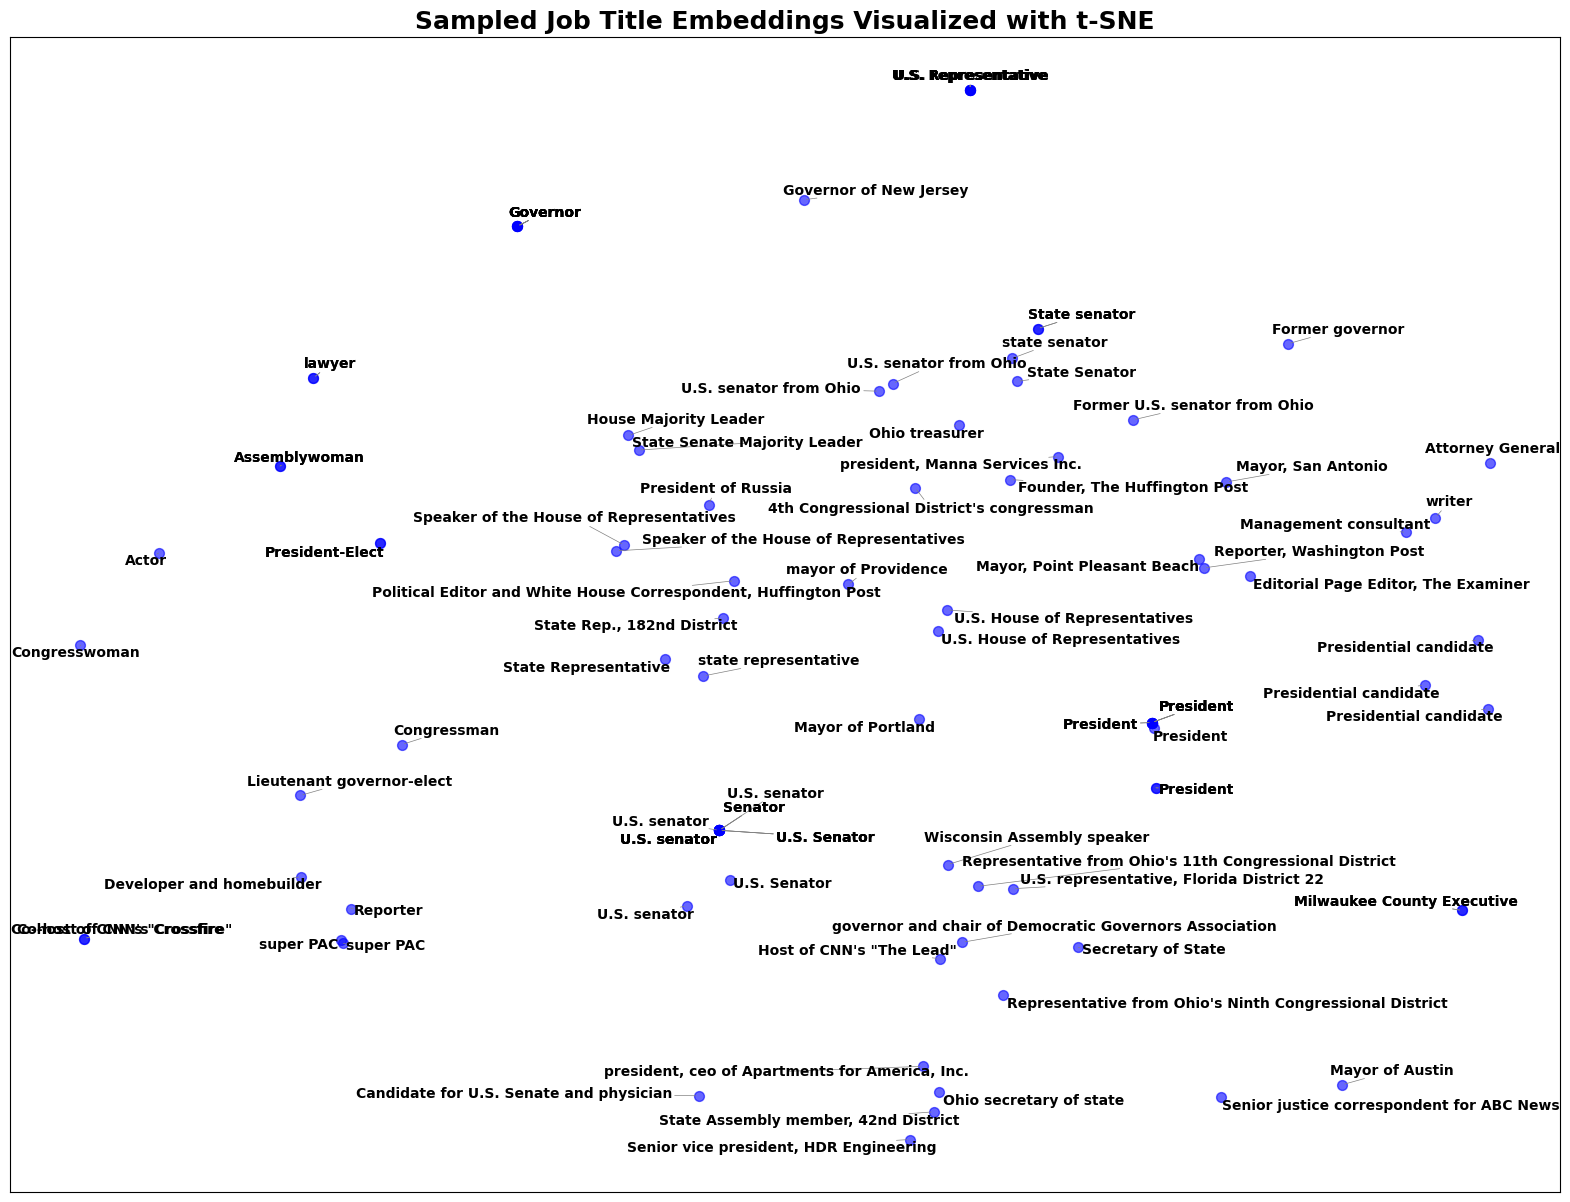

In [91]:
# Filter out rows with NaN job titles
filtered_data = train_data.dropna(subset=['job_title'])

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(filtered_data['job_title_embedding'].tolist())
job_titles_filtered = filtered_data['job_title'].values

# Apply t-SNE with fine-tuned parameters
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 100  # Adjust the subset size as needed
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings with increased figure size
plt.figure(figsize=(20, 15))  # Increase figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], job_titles_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Sampled Job Title Embeddings Visualized with t-SNE', fontsize=18, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


Optional: Apply K-means Clustering and Re-visualize

In [94]:
pip install adjustText


Note: you may need to restart the kernel to use updated packages.


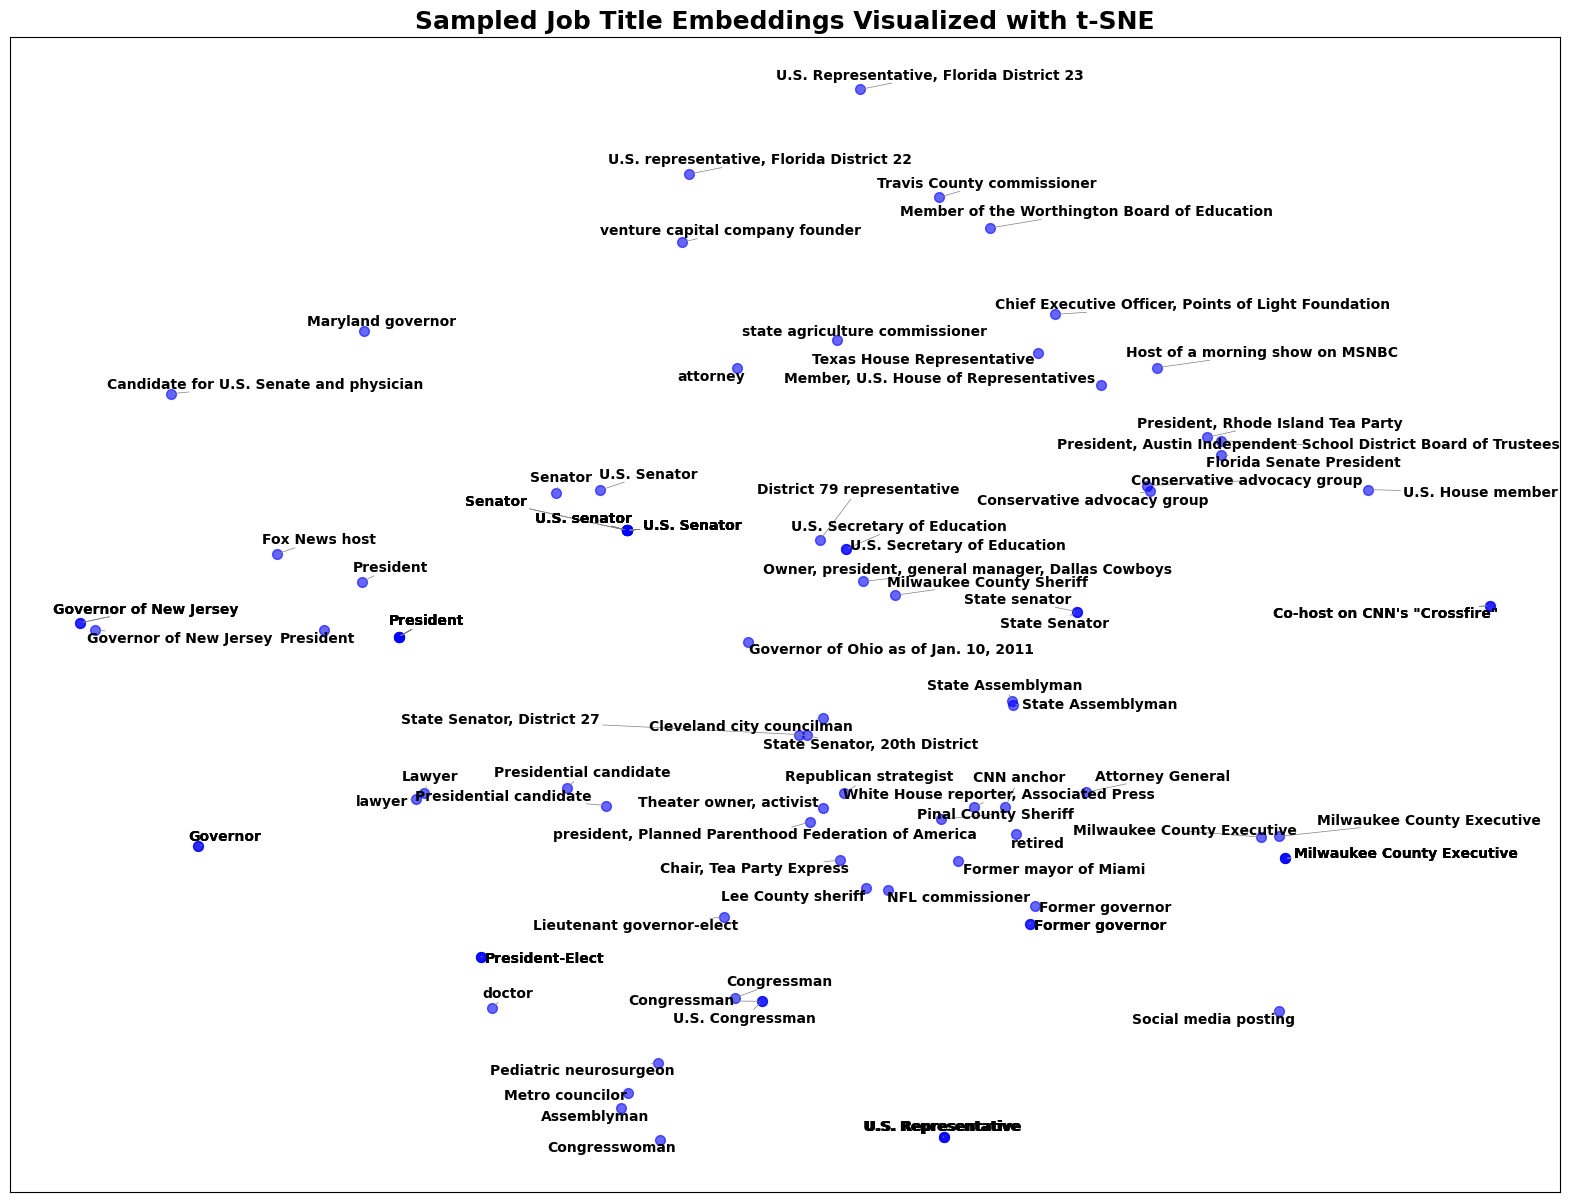

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Filter out rows with NaN job titles
filtered_data = train_data.dropna(subset=['job_title'])

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(filtered_data['job_title_embedding'].tolist())
job_titles_filtered = filtered_data['job_title'].values

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 100  # Adjust the subset size as needed
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings with increased figure size
plt.figure(figsize=(20, 15))  # Increase figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], job_titles_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels similar to the example
plt.title('Sampled Job Title Embeddings Visualized with t-SNE', fontsize=18, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


In [87]:
# Apply t-SNE with fine-tuned parameters
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)


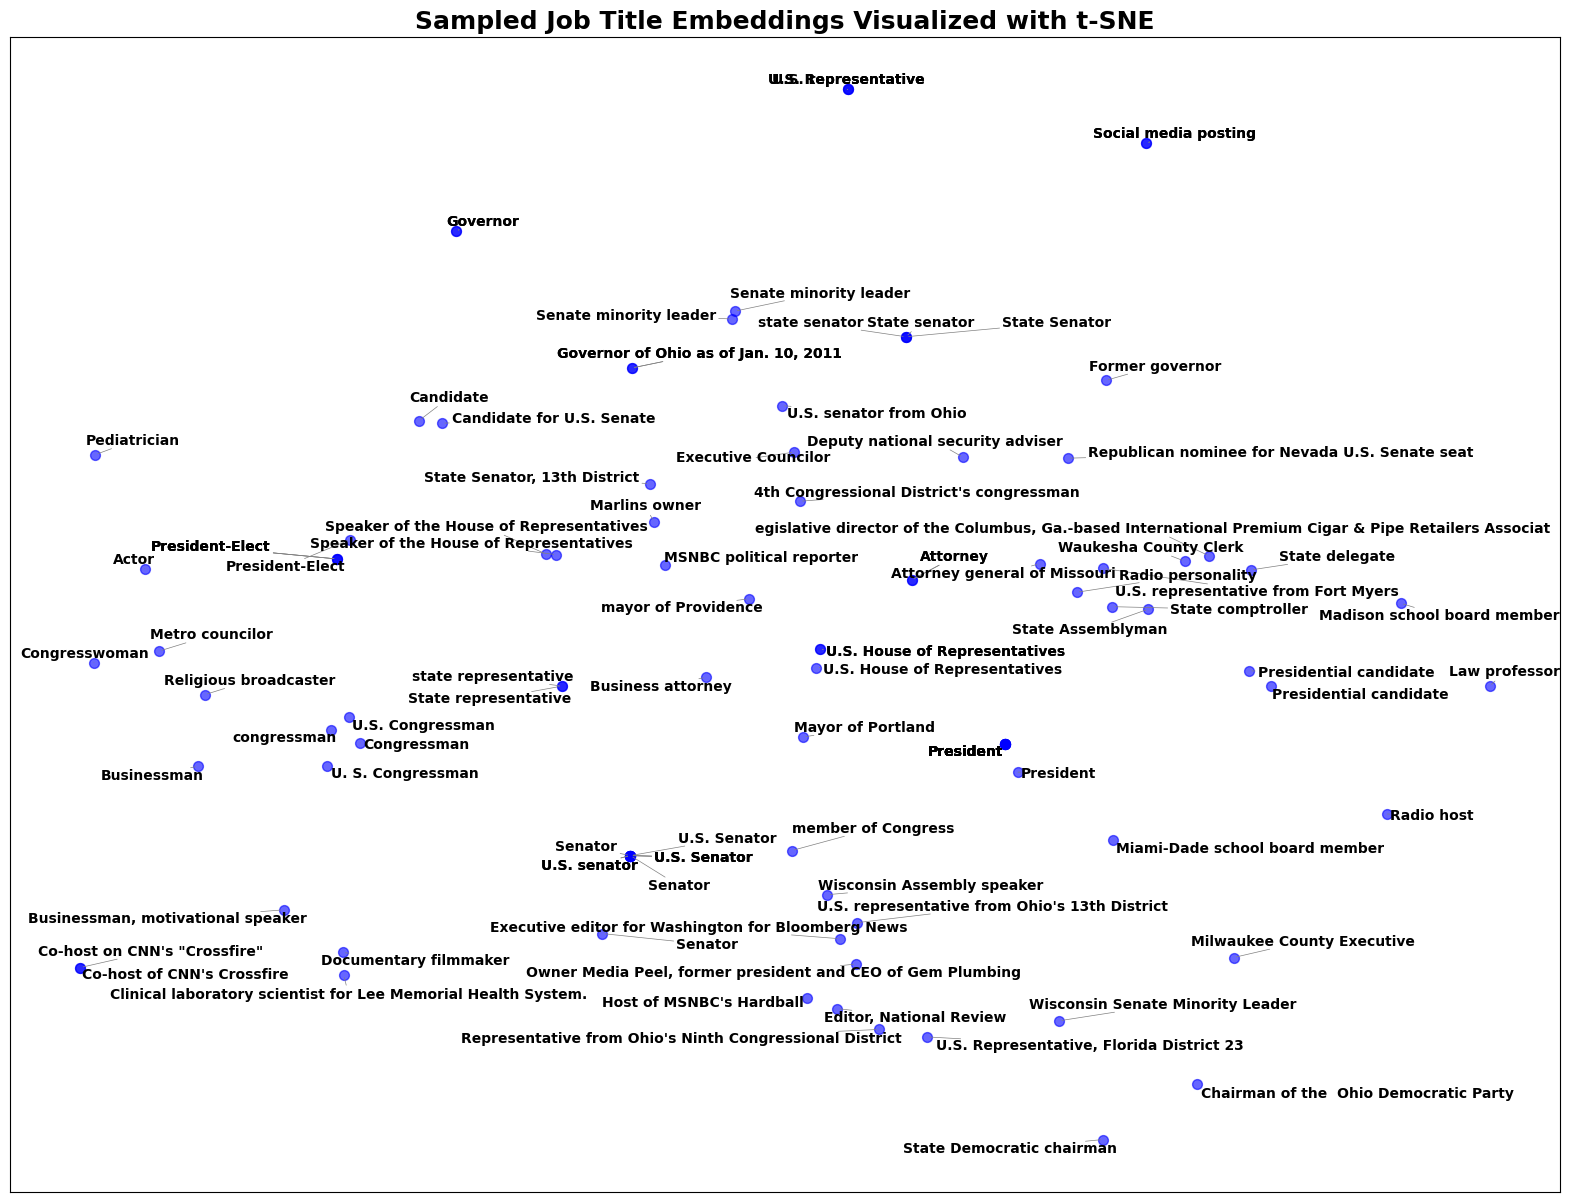

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Filter out rows with NaN job titles
filtered_data = train_data.dropna(subset=['job_title'])

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(filtered_data['job_title_embedding'].tolist())
job_titles_filtered = filtered_data['job_title'].values

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)


# Sample a subset of the data for clearer visualization
subset_size = 100  # Adjust the subset size as needed
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings with increased figure size
plt.figure(figsize=(20, 15))  # Increase figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], job_titles_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels similar to the example
plt.title('Sampled Job Title Embeddings Visualized with t-SNE', fontsize=18, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


In [97]:
pip install umap-learn


  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
Using cached umap_learn-0.5.6-py3-none-any.whl (85 kB)
Note: you may need to restart the kernel to use updated packages.


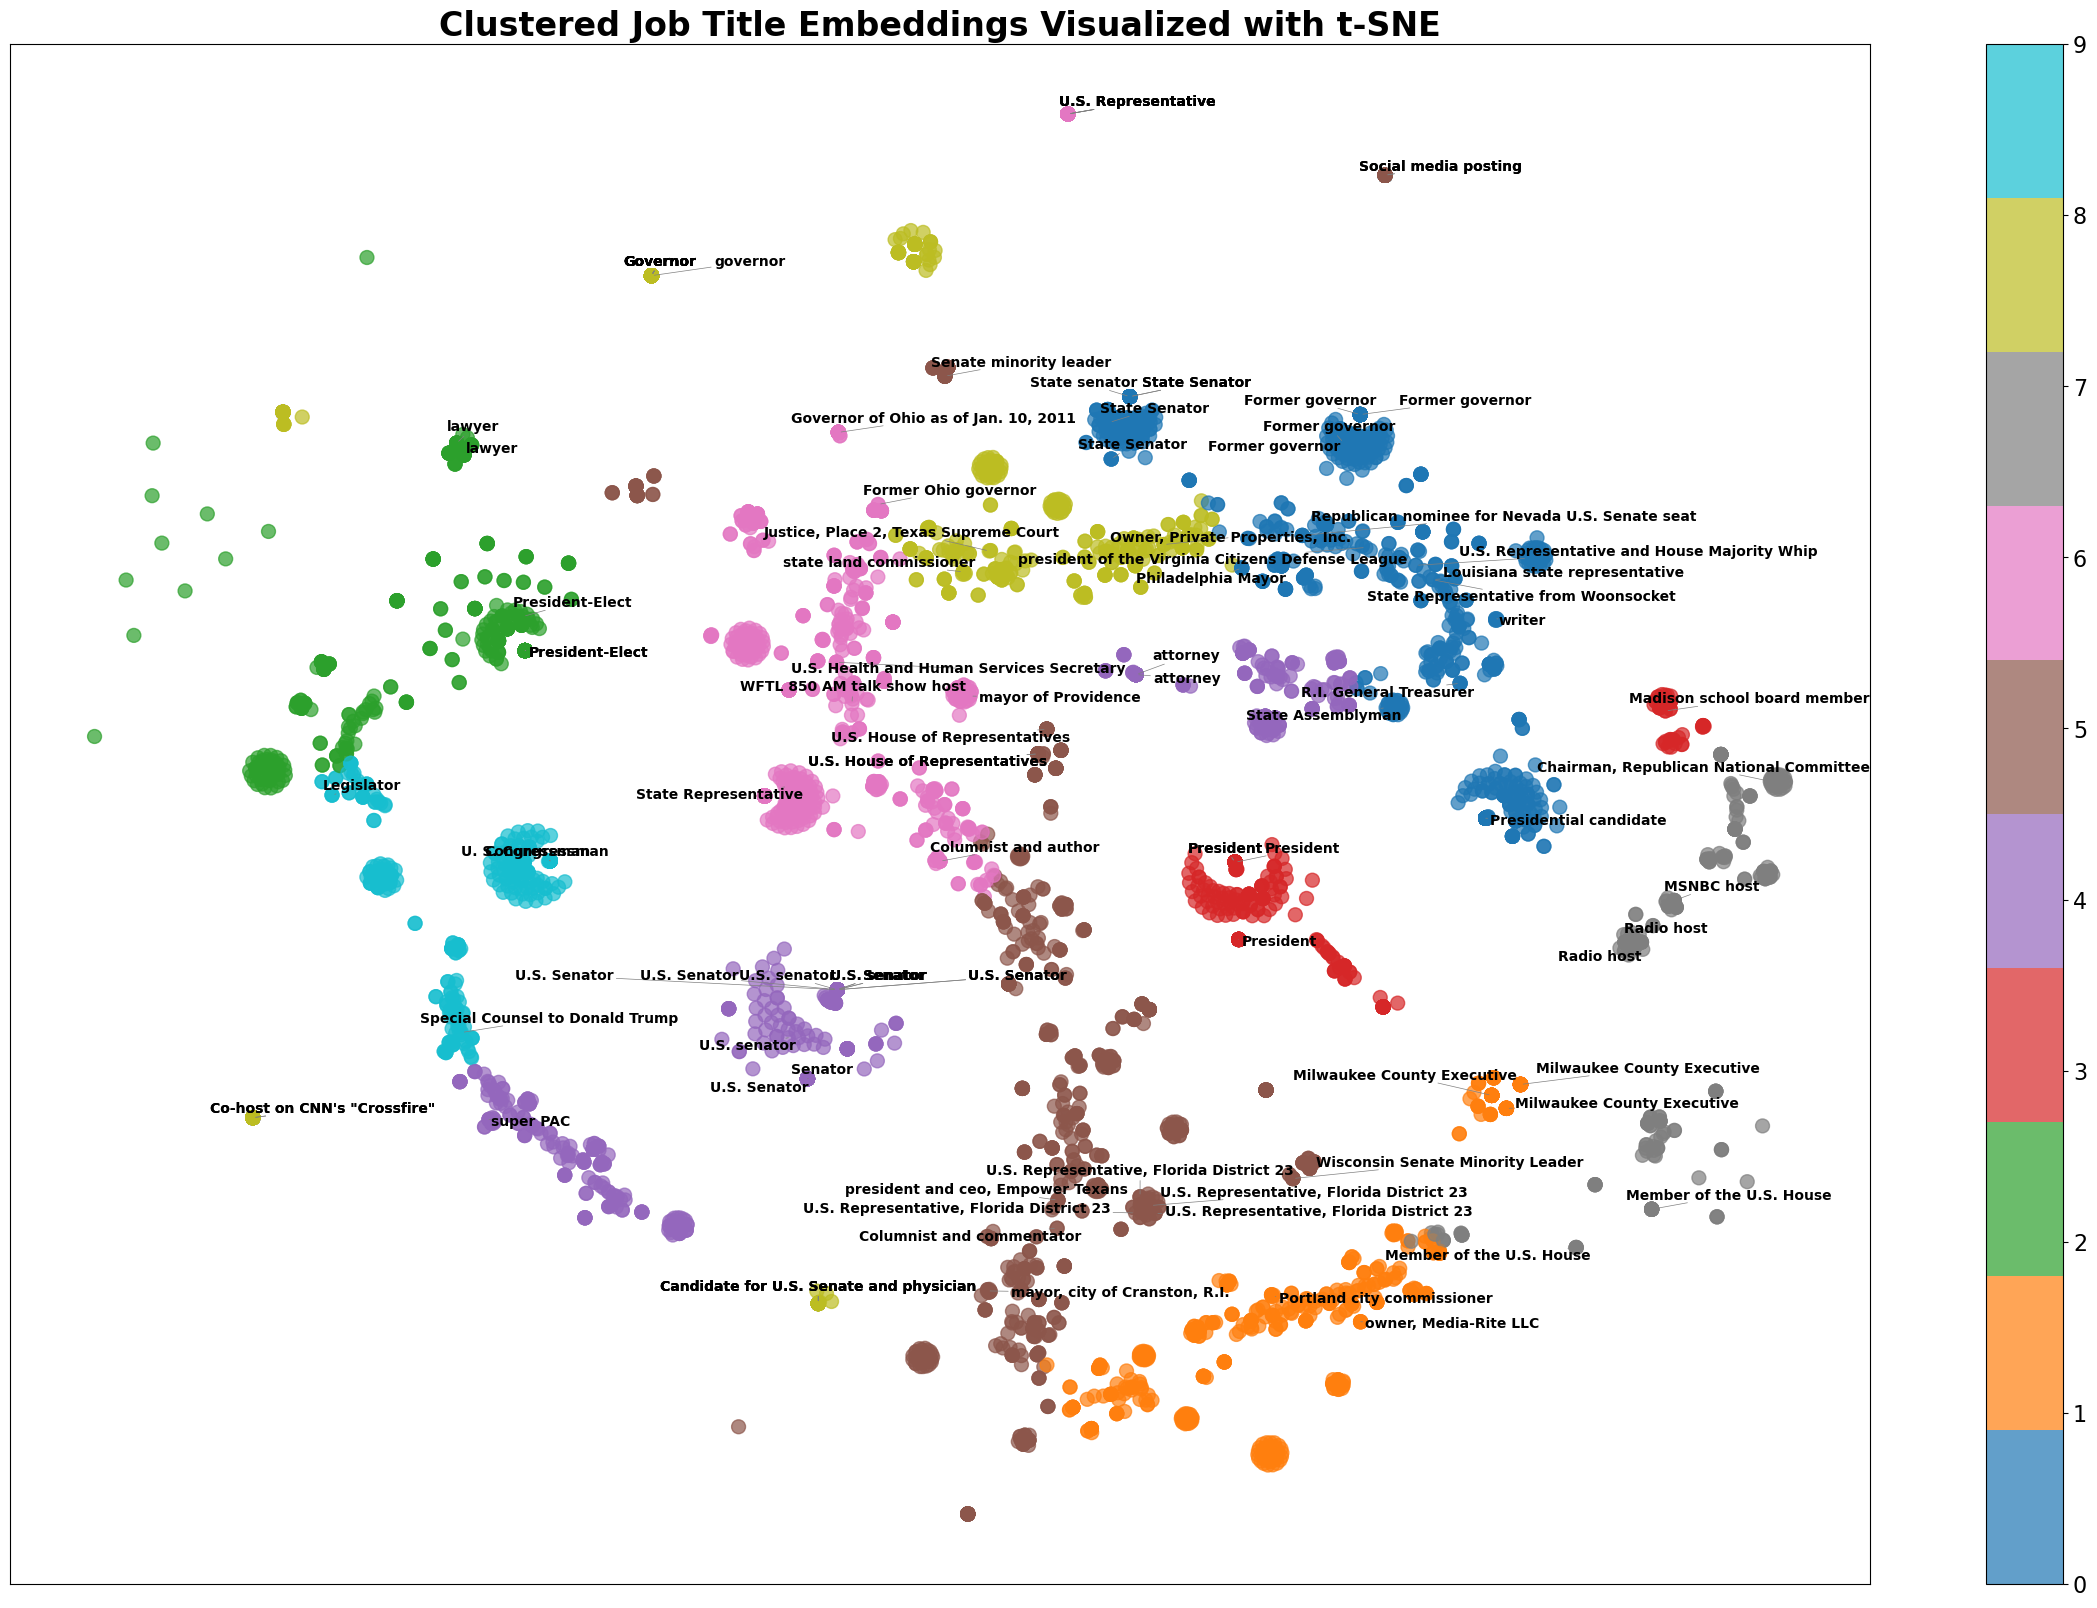

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Increase the subset size if you want to label more points
subset_size = 100  # You can adjust this number

# Sample a subset of the data
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Increase the figure size for better readability
plt.figure(figsize=(30, 20))  # Make the figure larger

# Plot the scatter plot
scatter = plt.scatter(embeddings_2d_tsne_filtered[:, 0], embeddings_2d_tsne_filtered[:, 1], 
                      c=filtered_data['cluster'], cmap='tab10', s=100, alpha=0.7)  # Increase marker size

# Add colorbar with adjusted tick size
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.ax.tick_params(labelsize=16)  # Increase colorbar label size

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], 
                          job_titles_filtered[i], fontsize=10, ha='center', fontweight='bold'))  # Increase font size

# Use adjustText to minimize overlap on the subset
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels with larger font size
plt.title('Clustered Job Title Embeddings Visualized with t-SNE', fontsize=24, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()
